In [1]:
#%matplotlib widget
import nest
import numpy as np
from scipy import interpolate, signal
import matplotlib.pyplot as plt
from nest import raster_plot
from pyinform import transfer_entropy, utils, shannon, dist
from scipy.stats import ttest_ind

from joblib import Parallel, delayed


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 24 2024 10:11:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [15]:
data = np.load('/home/justidy1/LabCode/IctalPlaceCell/data/line_maze_data_spread.npz', allow_pickle=True)

def stim_cue_net(conn_CA3_to_CA3,conn_CA3_to_CA1,
                 sim_time,cue_location,cue_time,cue_duration=20,cue_rate=30,cue_weight=50,bg_w=15,
                 seed=1234):
    # making a new newtork
    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.rng_seed=seed

    # Create CA3 and CA1 populations of adaptive exponential integrate-and-fire neurons
    N_pyr = 1250
    tau_decay_pyr_e = 9.0
    tau_rise_pyr_e = 1.0
    tau_decay_pyr_i = 3.0
    tau_rise_pyr_i = 0.3
    tau_decay_gc = 5.4
    tau_rise_gc = 0.65

    pyr_spec = {'C_m':180,'g_L':4.3,'E_L':-75,'Delta_T':4.23,'V_th':-24,'V_peak':-3.25,'V_reset':-29.7,'t_ref':5.9,
                'tau_w':84.93,'a':-0.27,'b':206.84,'E_rev':[0,-90,0],
                'tau_rise':[tau_rise_pyr_e,tau_rise_pyr_i,tau_rise_gc],'tau_decay':[tau_decay_pyr_e,tau_decay_pyr_i,tau_decay_gc]}
    CA3_pyr_aeif = nest.Create("aeif_cond_beta_multisynapse", N_pyr, pyr_spec)
    CA1_pyr_aeif = nest.Create("aeif_cond_beta_multisynapse", N_pyr, pyr_spec)
    # make interneurons in CA3 and CA1
    N_int = 250
    int_spec = {'C_m':118,'g_L':7.5,'E_L':-74,'Delta_T':4.6,'V_th':-57.7,'V_peak':-34.78,'V_reset':-65,'t_ref':1,
                'tau_w':178.58,'a':3.05,'b':0.91,'E_rev':[0,-90],
                'tau_rise':[tau_rise_pyr_e,tau_rise_pyr_i],'tau_decay':[tau_decay_pyr_e,tau_decay_pyr_i]}
    CA3_int_aeif = nest.Create("aeif_cond_beta_multisynapse", N_int, int_spec)
    CA1_int_aeif = nest.Create("aeif_cond_beta_multisynapse", N_int, int_spec)

    # connect the CA3 and CA1 populations with static synapses with the weights learned from the previous simulation
    # the order of nodes is presevered since the neurons are created in the same order
    nest.Connect(conn_CA3_to_CA3['source'], conn_CA3_to_CA3['target'], 
                'one_to_one', syn_spec={'synapse_model':'static_synapse','weight': np.array(conn_CA3_to_CA3['weight']), 'receptor_type':1})
    nest.Connect(conn_CA3_to_CA1['source'], conn_CA3_to_CA1['target'], 
                'one_to_one', syn_spec={'synapse_model':'static_synapse','weight': np.array(conn_CA3_to_CA1['weight']), 'receptor_type':1})

    # now we wire pyr to int with a probability of 0.1
    nest.Connect(CA3_pyr_aeif, CA3_int_aeif, syn_spec={'weight': 0.85, 'receptor_type':1}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,'allow_autapses': False})
    nest.Connect(CA1_pyr_aeif, CA1_int_aeif, syn_spec={'weight': 0.85, 'receptor_type':1}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,'allow_autapses': False})

    # connect the interneurons with each other with a probability of 0.25
    nest.Connect(CA3_int_aeif, CA3_int_aeif, syn_spec={'weight': 5, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})
    nest.Connect(CA1_int_aeif, CA1_int_aeif, syn_spec={'weight': 5, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})

    # and the interneurons to the pyramidal cells with a probability of 0.25
    nest.Connect(CA3_int_aeif, CA3_pyr_aeif, syn_spec={'weight': 0.6, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})
    nest.Connect(CA1_int_aeif, CA1_pyr_aeif, syn_spec={'weight': 0.6, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})

    # create a stim to drive all the CA3 pyramidal cells
    stim = nest.Create("poisson_generator",1,{'rate': 20.0})
    nest.Connect(stim, CA3_pyr_aeif, syn_spec={'weight': bg_w, 'receptor_type':3}, conn_spec={'rule': 'all_to_all'})

    # create a cue to drive a subset of the CA3 pyramidal cells
    cue = nest.Create("inhomogeneous_poisson_generator",1,{'rate_times': [1,cue_time,cue_time+cue_duration],'rate_values': [0,cue_rate,0]})
    nest.Connect(cue, CA3_pyr_aeif[cue_location], syn_spec={'weight': cue_weight, 'receptor_type':3}, conn_spec={'rule': 'all_to_all'})

    # monitor the spiking activity of the CA3 and CA1 populations
    spike_detector = nest.Create("spike_recorder")
    nest.Connect(CA3_pyr_aeif, spike_detector)
    nest.Connect(CA1_pyr_aeif, spike_detector)
    nest.Connect(CA3_int_aeif, spike_detector)
    nest.Connect(CA1_int_aeif, spike_detector)

    # compute the CA3 and CA1 LFP
    CA3_multimeter = nest.Create("multimeter",1,{'record_from':['V_m','g_1','g_2','g_3'],'interval':1})
    CA1_multimeter = nest.Create("multimeter",1,{'record_from':['V_m','g_1','g_2'],'interval':1})
    nest.Connect(CA3_multimeter, CA3_pyr_aeif, conn_spec={'rule': 'fixed_outdegree', 'outdegree': 200,'allow_multapses': False})
    nest.Connect(CA1_multimeter, CA1_pyr_aeif, conn_spec={'rule': 'fixed_outdegree', 'outdegree': 200,'allow_multapses': False})

    # simulate the network
    nest.Simulate(sim_time)

    # get the spikes
    spikes = nest.GetStatus(spike_detector,keys='events')[0]

    # get the LFP
    CA3_recordings = nest.GetStatus(CA3_multimeter,keys='events')[0]
    CA1_recordings = nest.GetStatus(CA1_multimeter,keys='events')[0]
                                                                          
    CA3_lfp = CA3_recordings['g_1']*(CA3_recordings['V_m']-0) + CA3_recordings['g_2']*(CA3_recordings['V_m']--90) + CA3_recordings['g_3']*(CA3_recordings['V_m']-0) #pA
    CA1_lfp = CA1_recordings['g_1']*(CA1_recordings['V_m']-0) + CA1_recordings['g_2']*(CA1_recordings['V_m']--90) # pA
    CA3_lfp *= (1/(4*np.pi*0.3*5e-6))*1e-9 #mV
    CA1_lfp *= (1/(4*np.pi*0.3*5e-6))*1e-9

    return spikes,CA3_lfp,CA1_lfp,CA3_recordings['times'],CA1_recordings['times'],CA3_recordings['senders'],CA1_recordings['senders']

def placerange_to_indexes(xlow,xhigh,pf):
    return np.argwhere((pf>xlow) & (pf<xhigh)).flatten()

def sim_wrapper(data,wh,ictal,sim_time,cue_locations,cue_time,cue_duration=20,cue_rate=30,cue_weight=50,bg_w=15,seed=1234,spread=False):
    if ictal:
        if spread:
            conn_CA3_to_CA3=data['conn_CA3_to_CA3_ictal_spread'][wh]
            conn_CA3_to_CA1=data['conn_CA3_to_CA1_ictal_spread'][wh]
            pf_CA3 = data['all_pf_CA3_ictal_spread'][wh]
            pf_CA1 = data['all_pf_CA1_ictal_spread'][wh]
        else:
            conn_CA3_to_CA3=data['conn_CA3_to_CA3_ictal'][wh]
            conn_CA3_to_CA1=data['conn_CA3_to_CA1_ictal'][wh]
            pf_CA3 = data['all_pf_CA3_ictal'][wh]
            pf_CA1 = data['all_pf_CA1_ictal'][wh]
    else:
        conn_CA3_to_CA3=data['conn_CA3_to_CA3_controls'][wh]
        conn_CA3_to_CA1=data['conn_CA3_to_CA1_controls'][wh]
        pf_CA3 = data['all_pf_CA3_controls'][wh]
        pf_CA1 = data['all_pf_CA1_controls'][wh]
    
    spikes,CA3_lfp,CA1_lfp,CA3_lfp_t,CA1_lfp_t,CA3_lfp_s,CA1_lfp_s = stim_cue_net(conn_CA3_to_CA3,conn_CA3_to_CA1,
                                                                                         sim_time,placerange_to_indexes(cue_locations[0],cue_locations[1],pf_CA3),
                                                                                         cue_time,cue_duration,cue_rate,cue_weight,bg_w,seed)
    lfp_sig_ts = np.arange(0,np.max(CA3_lfp_t),1)+1
    CA3_lfp_sig = np.zeros(len(lfp_sig_ts))
    CA1_lfp_sig = np.zeros(len(lfp_sig_ts))
    CA3_senders = np.unique(CA3_lfp_s)
    CA1_senders = np.unique(CA1_lfp_s)

    for send in CA3_senders:
        # interpolate the LFP signal
        f = interpolate.interp1d(CA3_lfp_t[CA3_lfp_s==send],CA3_lfp[CA3_lfp_s==send],fill_value='extrapolate')
        CA3_lfp_sig += f(lfp_sig_ts)

    for send in CA1_senders:
        # interpolate the LFP signal
        f = interpolate.interp1d(CA1_lfp_t[CA1_lfp_s==send],CA1_lfp[CA1_lfp_s==send],fill_value='extrapolate')
        CA1_lfp_sig += f(lfp_sig_ts)

    s_times = spikes['times']
    s_senders = spikes['senders']
    s_place_CA1 = np.zeros(len(s_times))
    s_place_CA3 = np.zeros(len(s_times))

    for i in range(len(s_times)):
        if s_senders[i] < len(pf_CA1)+1250 and s_senders[i] >= 1250:
            s_place_CA1[i] = pf_CA1[s_senders[i]-1250]
            s_place_CA3[i] = np.nan
        elif s_senders[i] < len(pf_CA3):
            s_place_CA3[i] = pf_CA3[s_senders[i]]
            s_place_CA1[i] = np.nan
        else:
            s_place_CA1[i] = np.nan
            s_place_CA3[i] = np.nan

    return s_times,s_senders,s_place_CA1,s_place_CA3,CA3_lfp_sig,CA1_lfp_sig,lfp_sig_ts,pf_CA3,pf_CA1


Sep 11 15:26:07 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Sep 11 15:26:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 1500
    Number of OpenMP threads: 16
    Not using MPI

Sep 11 15:26:08 SimulationManager::run [Info]: 
    Simulation finished.


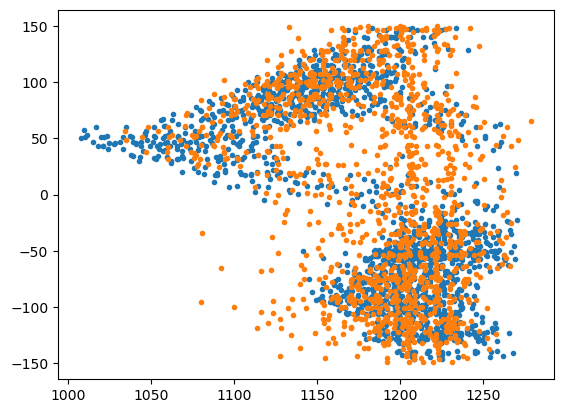

In [100]:
ictal=True
spread=True
wh=3
s_times,s_senders,s_place_CA1,s_place_CA3,CA3_lfp_sig,CA1_lfp_sig,lfp_sig_ts,pf_CA3,pf_CA1 = sim_wrapper(data,wh,ictal,1500,[40,60],1000,spread=spread,cue_weight=90,bg_w=10,seed=21)

plt.close('all')
plt.figure()
plt.plot(s_times,s_place_CA3,'.')
plt.plot(s_times,s_place_CA1,'.')
plt.show()

In [209]:
def compute_cue_spread(ictal_state,spread,cue_location,cue_weight,wh,seed=1234):
    # cue the network at the cue_location
    s_times,_,_,s_place_CA3,_,_,_,_,_ = sim_wrapper(data,wh,ictal_state,1350,cue_location,1000,spread=spread,cue_weight=cue_weight,bg_w=10,seed=seed)
    # count the number of spikes that overlap with each readout zone after the cue
    spike_counts_contaimination = np.sum((s_times > 1000) & ((s_place_CA3 < cue_location[0]) | (s_place_CA3 > cue_location[1])))
    spike_prop_contaimination = spike_counts_contaimination/np.sum((s_times > 1000) & ((s_place_CA3 > cue_location[0]) & (s_place_CA3 < cue_location[1])))
    return spike_counts_contaimination,spike_prop_contaimination

In [237]:
pos = np.arange(10,100,5)
cue_locations = [[x-10,x+10] for x in pos]
cue_weights = [80]
N_replicas = 10 # but fixing the network though to compare the effect of the cue without confounders like network variability
wh = 0

# spike_counts_contaimination_low_entropy = np.zeros((len(cue_locations),len(cue_weights),10))
# spike_counts_contaimination_high_entropy = np.zeros((len(cue_locations),len(cue_weights),10))

spike_counts_contaimination_low_entropy = np.zeros((len(cue_locations),len(cue_weights),N_replicas))
spike_counts_contaimination_high_entropy = np.zeros((len(cue_locations),len(cue_weights),N_replicas))

# repeat for each replica serially
for i in range(len(cue_locations)):
    for j in range(len(cue_weights)):
        for k in range(N_replicas):
            _,spike_counts_contaimination_low_entropy[i,j,k] = compute_cue_spread(True,False,cue_locations[i],cue_weights[j],wh,k+1)
            _,spike_counts_contaimination_high_entropy[i,j,k] = compute_cue_spread(True,True,cue_locations[i],cue_weights[j],wh,k+1)


Sep 11 17:03:10 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Sep 11 17:03:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 1350
    Number of OpenMP threads: 16
    Not using MPI

Sep 11 17:03:12 SimulationManager::run [Info]: 
    Simulation finished.

Sep 11 17:03:13 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Sep 11 17:03:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 1350
    Number of OpenMP threads: 16
    Not using MPI

Sep 11 17:03:14 SimulationManager::run [Info]: 
    Simulation finished.

Sep 11 17:03:15 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Sep 11 17:03:15 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 1350
    Number of OpenMP threads: 16
    Not using MPI

Sep 11 17:03:16 SimulationManager::run [Info

In [240]:
# save the results
np.savez('data/cue_spread.npz',
         spike_counts_contaimination_low_entropy=spike_counts_contaimination_low_entropy,
         spike_counts_contaimination_high_entropy=spike_counts_contaimination_high_entropy,
         wh_used=wh,pos=pos,cue_locations=cue_locations,cue_weights=cue_weights)

In [241]:
# load the results
data = np.load('data/cue_spread.npz',allow_pickle=True)
spike_counts_contaimination_low_entropy = data['spike_counts_contaimination_low_entropy']
spike_counts_contaimination_high_entropy = data['spike_counts_contaimination_high_entropy']
wh = data['wh_used']
pos = data['pos']
cue_locations = data['cue_locations']

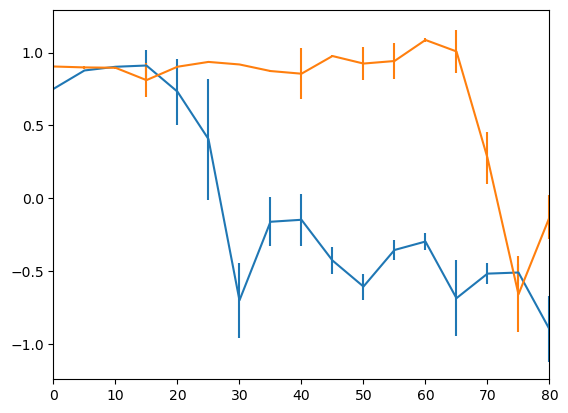

In [282]:
plt.close('all')
plt.figure()
ax = plt.subplot(111)
ax.errorbar(90-pos,np.log10(spike_counts_contaimination_low_entropy+1e-3).mean(axis=2).flatten(),yerr=np.log10(spike_counts_contaimination_low_entropy+1e-3).std(axis=2).flatten()/np.sqrt(N_replicas))
ax.errorbar(90-pos,np.log10(spike_counts_contaimination_high_entropy+1e-3).mean(axis=2).flatten(),yerr=np.log10(spike_counts_contaimination_high_entropy+1e-3).std(axis=2).flatten()/np.sqrt(N_replicas))
ax.set_xlim([0,80])
#plt.show()
plt.savefig('cue_spread.svg')

(0.0, 80.0)

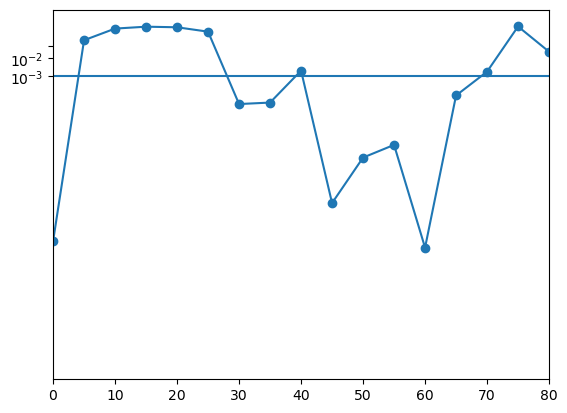

In [329]:
from scipy.stats import f_oneway, tukey_hsd, false_discovery_control

low_reshape = np.log10(spike_counts_contaimination_low_entropy+1e-3).reshape(len(cue_locations),len(cue_weights)*N_replicas)
high_reshape = np.log10(spike_counts_contaimination_high_entropy+1e-3).reshape(len(cue_locations),len(cue_weights)*N_replicas)
stat,p=f_oneway(low_reshape,high_reshape,axis=1)
plt.plot(90-pos,false_discovery_control(p),'-o')
plt.yscale('log')
plt.yticks([0.05,0.01,0.001])
plt.axhline(0.001)
plt.xlim([0,80])

(0.0, 80.0)

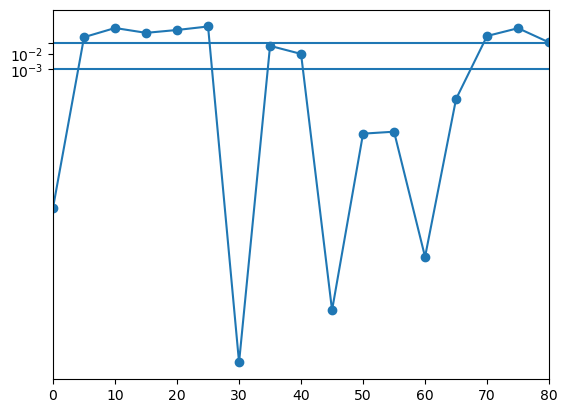

In [332]:
low_reshape = spike_counts_contaimination_low_entropy.reshape(len(cue_locations),len(cue_weights)*N_replicas)
high_reshape = spike_counts_contaimination_high_entropy.reshape(len(cue_locations),len(cue_weights)*N_replicas)
stat,p=f_oneway(low_reshape,high_reshape,axis=1)
plt.plot(90-pos,false_discovery_control(p),'-o')
plt.yscale('log')
plt.yticks([0.05,0.01,0.001])
plt.axhline(0.001)
plt.axhline(0.05)
plt.xlim([0,80])

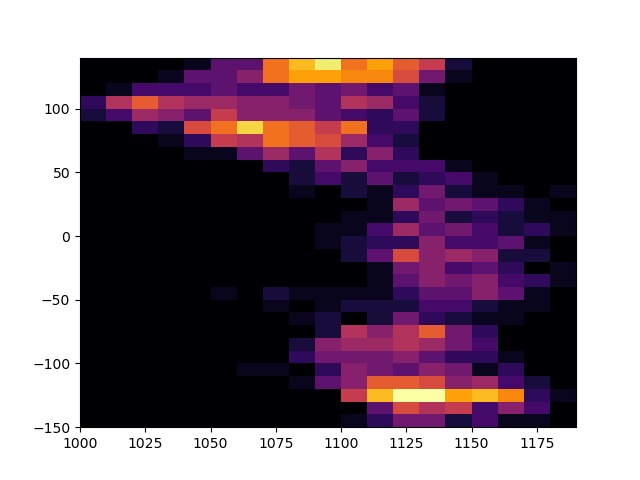

In [161]:
plt.close('all')
plt.figure()
plt.hist2d(s_times,s_place_CA3,bins=[np.arange(1000,1200,10),np.arange(-150,150,10)],cmap='inferno')
plt.show()

In [162]:
plt.savefig('hist_near_cue_ictal.svg')

In [11]:
# if we cue the network at a specific location, does it generalize to other locations?
# count the number of spikes that overlap with each readout zone (a tuple of start and end place fields)
def compute_cue_generalization(ictal_state,spread,cue_location,readout_zones,wh,seed=1234):
    # cue the network at the cue_location
    s_times,s_senders,s_place_CA1,s_place_CA3,CA3_lfp_sig,CA1_lfp_sig,lfp_sig_ts,pf_CA3,pf_CA1 = sim_wrapper(data,wh,ictal_state,1350,cue_location,1000,spread=spread,cue_weight=500,bg_w=10,seed=seed)
    # count the number of spikes that overlap with each readout zone after the cue
    spike_counts = np.zeros(len(readout_zones))
    for i in range(len(readout_zones)):
        spike_counts[i] = np.sum((s_times > 1000) & (s_place_CA3 > readout_zones[i][0]) & (s_place_CA3 < readout_zones[i][1]))

    return spike_counts

compute_cue_generalization(False,False,[70,90],[[70,90],[90,110],[-110,-90]],0,seed=2)


Sep 09 13:48:37 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Sep 09 13:48:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 1350
    Number of OpenMP threads: 16
    Not using MPI

Sep 09 13:48:38 SimulationManager::run [Info]: 
    Simulation finished.


array([131., 162.,   0.])

In [14]:
# compute the cue generalization for all the control and ictal networks
cue_near = [70,90]
cue_far = [10,30]
readout_zones_near = [[70,90],[90,110],[-110,-90]]
readout_zones_far = [[10,30],[90,110],[-110,-90]]
N_sim = 300

cue_near_gen_ctrl = np.zeros((N_sim,3))
cue_far_gen_ctrl = np.zeros((N_sim,3))
cue_near_gen_ictal = np.zeros((N_sim,3))
cue_far_gen_ictal = np.zeros((N_sim,3))
cue_near_gen_spread = np.zeros((N_sim,3))
cue_far_gen_spread = np.zeros((N_sim,3))

for i in range(N_sim):
    # pick a random network
    wh = np.random.randint(0,9)

    # compute the cue generalization 
    cue_near_gen_ctrl[i,:] = compute_cue_generalization(False,False,cue_near,readout_zones_near,wh,seed=i+1)
    cue_far_gen_ctrl[i,:] = compute_cue_generalization(False,False,cue_far,readout_zones_far,wh,seed=i+1)

    cue_near_gen_ictal[i,:] = compute_cue_generalization(True,False,cue_near,readout_zones_near,wh,seed=i+1)
    cue_far_gen_ictal[i,:] = compute_cue_generalization(True,False,cue_far,readout_zones_far,wh,seed=i+1)

    cue_near_gen_spread[i,:] = compute_cue_generalization(True,True,cue_near,readout_zones_near,wh,seed=i+1)
    cue_far_gen_spread[i,:] = compute_cue_generalization(True,True,cue_far,readout_zones_far,wh,seed=i+1)

# save the data
np.savez('./data/cue_generalization_large_spread.npz',
         cue_near_gen_ctrl=cue_near_gen_ctrl,cue_far_gen_ctrl=cue_far_gen_ctrl,
         cue_near_gen_ictal=cue_near_gen_ictal,cue_far_gen_ictal=cue_far_gen_ictal,
         cue_near_gen_spread=cue_near_gen_spread,cue_far_gen_spread=cue_far_gen_spread)


Sep 09 13:49:38 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Sep 09 13:49:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 1350
    Number of OpenMP threads: 16
    Not using MPI

Sep 09 13:49:39 SimulationManager::run [Info]: 
    Simulation finished.

Sep 09 13:49:40 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Sep 09 13:49:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 1350
    Number of OpenMP threads: 16
    Not using MPI

Sep 09 13:49:41 SimulationManager::run [Info]: 
    Simulation finished.

Sep 09 13:49:41 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Sep 09 13:49:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 1350
    Number of OpenMP threads: 16
    Not using MPI

Sep 09 13:49:43 SimulationManager::run [Info

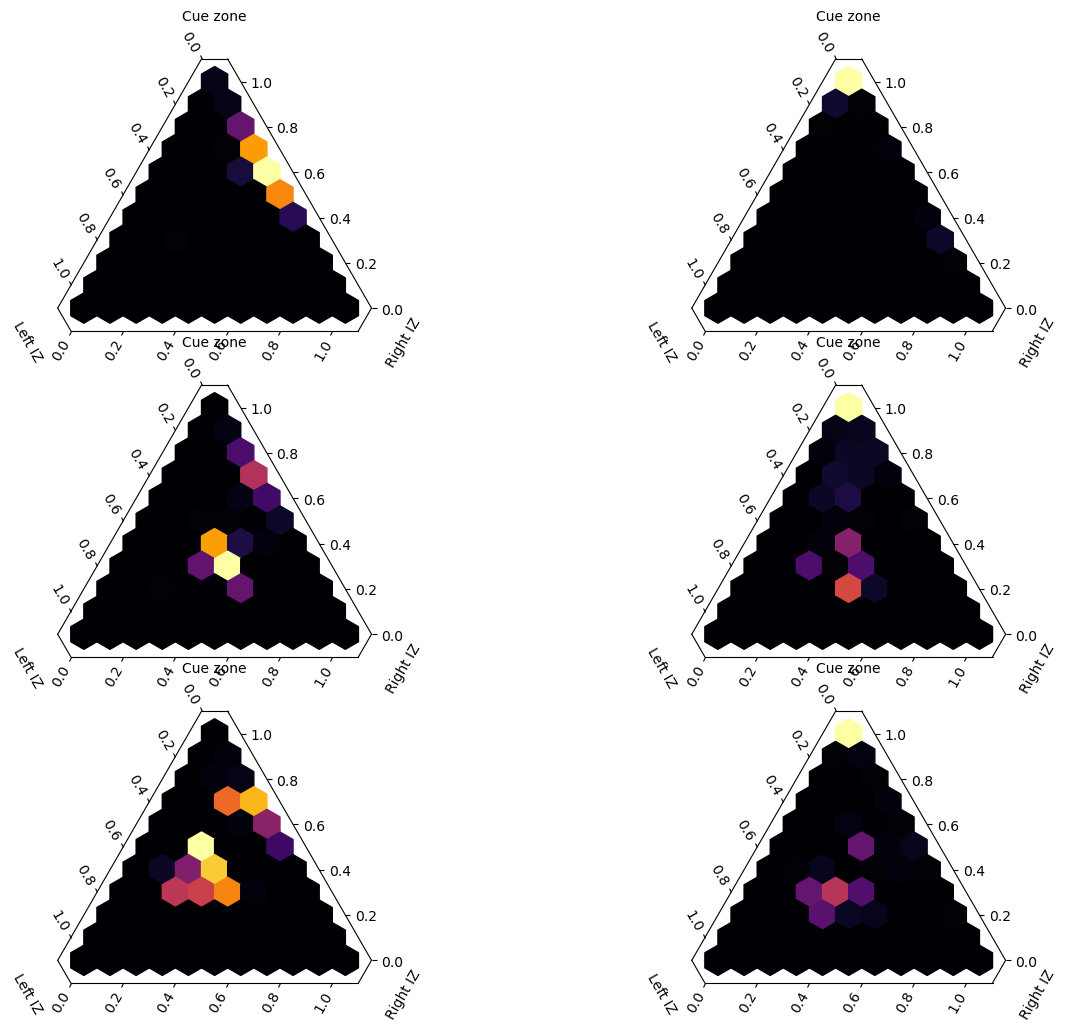

In [2]:
# compare the cue generalization between the control and ictal networks
cue_near_gen_ctrl = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_near_gen_ctrl']
cue_far_gen_ctrl = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_far_gen_ctrl']
cue_near_gen_ictal = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_near_gen_ictal']
cue_far_gen_ictal = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_far_gen_ictal']
cue_near_gen_spread = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_near_gen_spread']
cue_far_gen_spread = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_far_gen_spread']

# convert to proportion of spikes
cue_near_gen_ctrl /= np.sum(cue_near_gen_ctrl,axis=1)[:,None]
cue_far_gen_ctrl /= np.sum(cue_far_gen_ctrl,axis=1)[:,None]
cue_near_gen_ictal /= np.sum(cue_near_gen_ictal,axis=1)[:,None]
cue_far_gen_ictal /= np.sum(cue_far_gen_ictal,axis=1)[:,None]
cue_near_gen_spread /= np.sum(cue_near_gen_spread,axis=1)[:,None]
cue_far_gen_spread /= np.sum(cue_far_gen_spread,axis=1)[:,None]

# plot the cue generalization as a ternary plot
import mpltern

gridsize = 10

plt.close('all')
plt.figure(figsize=(15,12))
ax1=plt.subplot(3,2,1,projection='ternary')
ax1.hexbin(cue_near_gen_ctrl[:,0],cue_near_gen_ctrl[:,2],cue_near_gen_ctrl[:,1],gridsize=gridsize,cmap='inferno')
#ax1.scatter(cue_near_gen_ctrl[:,0],cue_near_gen_ctrl[:,2],cue_near_gen_ctrl[:,1],marker='.')
ax1.set_ternary_lim(-0.1,1.1,-0.1,1.1,-0.1,1.1)
# label the axes
ax1.set_tlabel('Cue zone')
ax1.set_llabel('Left IZ')
ax1.set_rlabel('Right IZ')

ax2=plt.subplot(3,2,2,projection='ternary')
ax2.hexbin(cue_far_gen_ctrl[:,0],cue_far_gen_ctrl[:,2],cue_far_gen_ctrl[:,1],gridsize=gridsize,cmap='inferno')
#ax2.scatter(cue_far_gen_ctrl[:,0],cue_far_gen_ctrl[:,2],cue_far_gen_ctrl[:,1],marker='.')
ax2.set_ternary_lim(-0.1,1.1,-0.1,1.1,-0.1,1.1)
# label the axes
ax2.set_tlabel('Cue zone')
ax2.set_llabel('Left IZ')
ax2.set_rlabel('Right IZ')

ax3=plt.subplot(3,2,3,projection='ternary')
ax3.hexbin(cue_near_gen_ictal[:,0],cue_near_gen_ictal[:,2],cue_near_gen_ictal[:,1],gridsize=gridsize,cmap='inferno')
#ax3.scatter(cue_near_gen_ictal[:,0],cue_near_gen_ictal[:,2],cue_near_gen_ictal[:,1],marker='.')
ax3.set_ternary_lim(-0.1,1.1,-0.1,1.1,-0.1,1.1)
# label the axes
ax3.set_tlabel('Cue zone')
ax3.set_llabel('Left IZ')
ax3.set_rlabel('Right IZ')

ax4=plt.subplot(3,2,4,projection='ternary')
ax4.hexbin(cue_far_gen_ictal[:,0],cue_far_gen_ictal[:,2],cue_far_gen_ictal[:,1],gridsize=gridsize,cmap='inferno')
#ax4.scatter(cue_far_gen_ictal[:,0],cue_far_gen_ictal[:,2],cue_far_gen_ictal[:,1],marker='.')
ax4.set_ternary_lim(-0.1,1.1,-0.1,1.1,-0.1,1.1)
# label the axes
ax4.set_tlabel('Cue zone')
ax4.set_llabel('Left IZ')
ax4.set_rlabel('Right IZ')

ax3=plt.subplot(3,2,5,projection='ternary')
ax3.hexbin(cue_near_gen_spread[:,0],cue_near_gen_spread[:,2],cue_near_gen_spread[:,1],gridsize=gridsize,cmap='inferno')
#ax3.scatter(cue_near_gen_ictal[:,0],cue_near_gen_ictal[:,2],cue_near_gen_ictal[:,1],marker='.')
ax3.set_ternary_lim(-0.1,1.1,-0.1,1.1,-0.1,1.1)
# label the axes
ax3.set_tlabel('Cue zone')
ax3.set_llabel('Left IZ')
ax3.set_rlabel('Right IZ')

ax4=plt.subplot(3,2,6,projection='ternary')
ax4.hexbin(cue_far_gen_spread[:,0],cue_far_gen_spread[:,2],cue_far_gen_spread[:,1],gridsize=gridsize,cmap='inferno')
#ax4.scatter(cue_far_gen_ictal[:,0],cue_far_gen_ictal[:,2],cue_far_gen_ictal[:,1],marker='.')
ax4.set_ternary_lim(-0.1,1.1,-0.1,1.1,-0.1,1.1)
# label the axes
ax4.set_tlabel('Cue zone')
ax4.set_llabel('Left IZ')
ax4.set_rlabel('Right IZ')

plt.show()

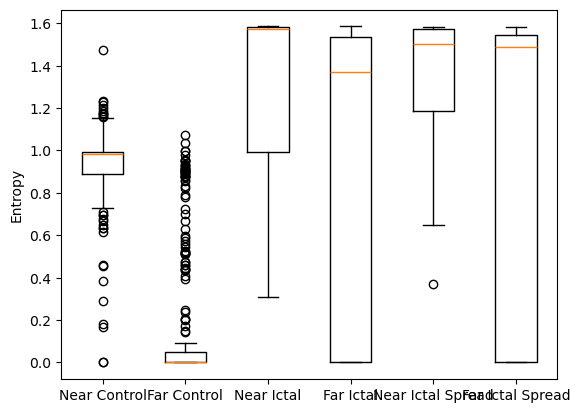

In [5]:
# compute cue generalization entropy (entropy of the distributions of spikes across the readout zones)
def compute_cu_entropy(cue_spike_dist):
    # compute the entropy of the distribution
    h = np.sum(-cue_spike_dist*np.log2(cue_spike_dist+1e-8))
    return h

cue_near_gen_ctrl = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_near_gen_ctrl']
cue_far_gen_ctrl = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_far_gen_ctrl']
cue_near_gen_ictal = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_near_gen_ictal']
cue_far_gen_ictal = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_far_gen_ictal']
cue_near_gen_spread = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_near_gen_spread']
cue_far_gen_spread = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_far_gen_spread']

cue_near_gen_ctrl /= np.sum(cue_near_gen_ctrl,axis=1)[:,None]
cue_far_gen_ctrl /= np.sum(cue_far_gen_ctrl,axis=1)[:,None]
cue_near_gen_ictal /= np.sum(cue_near_gen_ictal,axis=1)[:,None]
cue_far_gen_ictal /= np.sum(cue_far_gen_ictal,axis=1)[:,None]
cue_near_gen_spread /= np.sum(cue_near_gen_spread,axis=1)[:,None]
cue_far_gen_spread /= np.sum(cue_far_gen_spread,axis=1)[:,None]

cue_near_gen_ctrl_entropy = np.zeros(cue_near_gen_ctrl.shape[0])
cue_far_gen_ctrl_entropy = np.zeros(cue_far_gen_ctrl.shape[0])
cue_near_gen_ictal_entropy = np.zeros(cue_near_gen_ictal.shape[0])
cue_far_gen_ictal_entropy = np.zeros(cue_far_gen_ictal.shape[0])
cue_near_gen_spread_entropy = np.zeros(cue_near_gen_spread.shape[0])
cue_far_gen_spread_entropy = np.zeros(cue_far_gen_spread.shape[0])

for i in range(cue_near_gen_ctrl.shape[0]):
    cue_near_gen_ctrl_entropy[i] = compute_cu_entropy(cue_near_gen_ctrl[i,:])
    cue_far_gen_ctrl_entropy[i] = compute_cu_entropy(cue_far_gen_ctrl[i,:])
    cue_near_gen_ictal_entropy[i] = compute_cu_entropy(cue_near_gen_ictal[i,:])
    cue_far_gen_ictal_entropy[i] = compute_cu_entropy(cue_far_gen_ictal[i,:])
    cue_near_gen_spread_entropy[i] = compute_cu_entropy(cue_near_gen_spread[i,:])
    cue_far_gen_spread_entropy[i] = compute_cu_entropy(cue_far_gen_spread[i,:])

# plot the entropy of the cue generalization
plt.close('all')
plt.figure()
plt.boxplot([cue_near_gen_ctrl_entropy,cue_far_gen_ctrl_entropy,cue_near_gen_ictal_entropy,cue_far_gen_ictal_entropy,cue_near_gen_spread_entropy,cue_far_gen_spread_entropy])
plt.xticks([1,2,3,4,5,6],['Near Control','Far Control','Near Ictal','Far Ictal','Near Ictal Spread','Far Ictal Spread'])
plt.ylabel('Entropy')
plt.show()

In [9]:
from scipy.stats import kruskal, tukey_hsd

stat,p=kruskal(cue_near_gen_ctrl_entropy,cue_far_gen_ctrl_entropy,cue_near_gen_ictal_entropy,cue_far_gen_ictal_entropy,cue_near_gen_spread_entropy,cue_far_gen_spread_entropy)
p

6.442180841456069e-154

In [10]:
res=tukey_hsd(cue_near_gen_ctrl_entropy,cue_far_gen_ctrl_entropy,cue_near_gen_ictal_entropy,cue_far_gen_ictal_entropy,cue_near_gen_spread_entropy,cue_far_gen_spread_entropy)
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.779     0.000     0.672     0.887
 (0 - 2)     -0.428     0.000    -0.535    -0.320
 (0 - 3)     -0.018     0.996    -0.126     0.089
 (0 - 4)     -0.424     0.000    -0.531    -0.317
 (0 - 5)     -0.037     0.927    -0.144     0.071
 (1 - 0)     -0.779     0.000    -0.887    -0.672
 (1 - 2)     -1.207     0.000    -1.314    -1.100
 (1 - 3)     -0.798     0.000    -0.905    -0.691
 (1 - 4)     -1.203     0.000    -1.311    -1.096
 (1 - 5)     -0.816     0.000    -0.923    -0.709
 (2 - 0)      0.428     0.000     0.320     0.535
 (2 - 1)      1.207     0.000     1.100     1.314
 (2 - 3)      0.409     0.000     0.302     0.517
 (2 - 4)      0.004     1.000    -0.103     0.111
 (2 - 5)      0.391     0.000     0.284     0.498
 (3 - 0)      0.018     0.996    -0.089     0.126
 (3 - 1)      0.798     0.000     0.691     0.905
 (3 - 2)     -0.409     0.000   

In [14]:
res=tukey_hsd(cue_far_gen_ctrl_entropy,cue_far_gen_ictal_entropy,cue_far_gen_spread_entropy)
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.798     0.000    -0.913    -0.683
 (0 - 2)     -0.816     0.000    -0.931    -0.701
 (1 - 0)      0.798     0.000     0.683     0.913
 (1 - 2)     -0.018     0.927    -0.133     0.097
 (2 - 0)      0.816     0.000     0.701     0.931
 (2 - 1)      0.018     0.927    -0.097     0.133



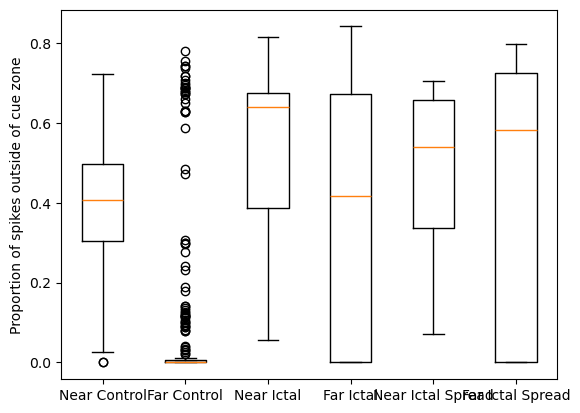

In [12]:
# compute proportion of spikes outside of the cue zone
def compute_outside_cue(cue_spike_dist):
    return np.sum(cue_spike_dist[[1,2]])/np.sum(cue_spike_dist)
    #return cue_spike_dist[[0]]/np.sum(cue_spike_dist)

cue_near_gen_ctrl = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_near_gen_ctrl']
cue_far_gen_ctrl = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_far_gen_ctrl']
cue_near_gen_ictal = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_near_gen_ictal']
cue_far_gen_ictal = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_far_gen_ictal']
cue_near_gen_spread = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_near_gen_spread']
cue_far_gen_spread = np.load('./data/cue_generalization_large_spread.npz',allow_pickle=True)['cue_far_gen_spread']

# for each simulation, compute the proportion of spikes outside of the cue zone
cue_near_gen_ctrl_outside = np.zeros(cue_near_gen_ctrl.shape[0])
cue_far_gen_ctrl_outside = np.zeros(cue_far_gen_ctrl.shape[0])
cue_near_gen_ictal_outside = np.zeros(cue_near_gen_ictal.shape[0])
cue_far_gen_ictal_outside = np.zeros(cue_far_gen_ictal.shape[0])
cue_near_gen_spread_outside = np.zeros(cue_near_gen_spread.shape[0])
cue_far_gen_spread_outside = np.zeros(cue_far_gen_spread.shape[0])

for i in range(cue_near_gen_ctrl.shape[0]):
    cue_near_gen_ctrl_outside[i] = compute_outside_cue(cue_near_gen_ctrl[i,:])
    cue_far_gen_ctrl_outside[i] = compute_outside_cue(cue_far_gen_ctrl[i,:])
    cue_near_gen_ictal_outside[i] = compute_outside_cue(cue_near_gen_ictal[i,:])
    cue_far_gen_ictal_outside[i] = compute_outside_cue(cue_far_gen_ictal[i,:])
    cue_near_gen_spread_outside[i] = compute_outside_cue(cue_near_gen_spread[i,:])
    cue_far_gen_spread_outside[i] = compute_outside_cue(cue_far_gen_spread[i,:])

# plot the proportion of spikes outside of the cue zone
plt.close('all')
plt.figure()
plt.boxplot([cue_near_gen_ctrl_outside,cue_far_gen_ctrl_outside,cue_near_gen_ictal_outside,cue_far_gen_ictal_outside,cue_near_gen_spread_outside,cue_far_gen_spread_outside])
plt.xticks([1,2,3,4,5,6],['Near Control','Far Control','Near Ictal','Far Ictal','Near Ictal Spread','Far Ictal Spread'])
plt.ylabel('Proportion of spikes outside of cue zone')
plt.show()

In [80]:
plt.savefig('proportion_outside_cue.svg')

In [23]:
from scipy.stats import kruskal, tukey_hsd

# perform a Kruskal-Wallis test to compare the proportion of spikes outside of the cue zone
stat,p=kruskal(cue_near_gen_ctrl_outside,cue_far_gen_ctrl_outside,cue_near_gen_ictal_outside,cue_far_gen_ictal_outside,cue_near_gen_spread_outside,cue_far_gen_spread_outside)
p

5.867934480850814e-101

In [24]:
res = tukey_hsd(cue_near_gen_ctrl_outside,cue_far_gen_ctrl_outside,cue_near_gen_ictal_outside,cue_far_gen_ictal_outside,cue_near_gen_spread_outside,cue_far_gen_spread_outside)
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.310     0.000     0.256     0.364
 (0 - 2)     -0.173     0.000    -0.227    -0.119
 (0 - 3)     -0.009     0.998    -0.063     0.045
 (0 - 4)     -0.134     0.000    -0.188    -0.080
 (0 - 5)     -0.040     0.283    -0.094     0.014
 (1 - 0)     -0.310     0.000    -0.364    -0.256
 (1 - 2)     -0.484     0.000    -0.538    -0.430
 (1 - 3)     -0.319     0.000    -0.373    -0.265
 (1 - 4)     -0.444     0.000    -0.498    -0.390
 (1 - 5)     -0.350     0.000    -0.404    -0.296
 (2 - 0)      0.173     0.000     0.119     0.227
 (2 - 1)      0.484     0.000     0.430     0.538
 (2 - 3)      0.165     0.000     0.111     0.219
 (2 - 4)      0.039     0.295    -0.014     0.093
 (2 - 5)      0.134     0.000     0.080     0.188
 (3 - 0)      0.009     0.998    -0.045     0.063
 (3 - 1)      0.319     0.000     0.265     0.373
 (3 - 2)     -0.165     0.000   

In [13]:
res = tukey_hsd(cue_far_gen_ctrl_outside,cue_far_gen_ictal_outside,cue_far_gen_spread_outside)
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.319     0.000    -0.375    -0.263
 (0 - 2)     -0.350     0.000    -0.406    -0.295
 (1 - 0)      0.319     0.000     0.263     0.375
 (1 - 2)     -0.031     0.383    -0.087     0.024
 (2 - 0)      0.350     0.000     0.295     0.406
 (2 - 1)      0.031     0.383    -0.024     0.087



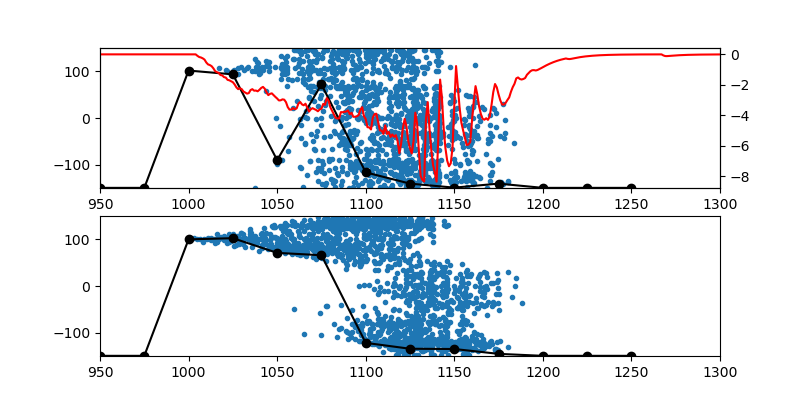

In [6]:
def population_vector(spike_times,senders,slist,pf,t_bin = 25):
    time_vec = np.arange(0,np.max(spike_times),t_bin)
    pop_vec = np.zeros((len(time_vec),len(slist)))
    
    # get the spikes and senders that belong to the cells in slist only 
    s_times = spike_times[np.isin(senders,slist)]
    s_senders = senders[np.isin(senders,slist)]-slist[0]
    # the pop vec at time t is the superposition of the place fields of the cells in slist that fired in the time window [t,t+t_bin]
    for i,t in enumerate(time_vec):
        # get the spikes that occured in the time window [t,t+t_bin]
        s_times_t = s_times[(s_times>=t) & (s_times<t+t_bin)]
        s_senders_t = s_senders[(s_times>=t) & (s_times<t+t_bin)]

        for j in range(len(s_times_t)):
            pop_vec[i,s_senders_t[j]] += 1 #+= pf[int(s_senders_t[j])]

    # get the pf values at the max of the population vector
    peak_vals = np.zeros(np.size(time_vec))
    for i in range(np.size(time_vec)):
        #max_val = np.amax(pop_vec[i,:])

        # # are there multiple indices with the same max value?
        # is_multiple_max = np.sum(pop_vec[i,:]==max_val) > 1

        # if is_multiple_max:
        #     max_idx = np.random.choice(np.argwhere(pop_vec[i,:]==max_val).flatten())
        # else:
        max_idx = np.argmax(pop_vec[i,:])

        peak_vals[i] = pf[max_idx]

    return peak_vals.flatten(),time_vec.flatten()

pop_vec_CA3,time_vec = population_vector(s_times,s_senders,np.arange(0,len(pf_CA3),1),pf_CA3)
pop_vec_CA1,time_vec = population_vector(s_times,s_senders,np.arange(1250,1250+len(pf_CA1),1),pf_CA1)

plt.close('all')
plt.figure(figsize=(8,4))
ax=plt.subplot(2,1,1)
plt.plot(s_times,s_place_CA1,'.')
plt.plot(time_vec,pop_vec_CA1,'-ok')
plt.ylim([-150,150])
plt.twinx()
plt.plot(lfp_sig_ts,CA1_lfp_sig,'-r')
plt.subplot(2,1,2,sharex=ax)
plt.plot(s_times,s_place_CA3,'.')
plt.plot(time_vec,pop_vec_CA3,'-ok')
plt.ylim([-150,150])
plt.xlim([950,1300])
plt.show()


Aug 03 19:21:31 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 03 19:21:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 1350
    Number of OpenMP threads: 16
    Not using MPI

Aug 03 19:21:33 SimulationManager::run [Info]: 
    Simulation finished.

Aug 03 19:21:33 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 03 19:21:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 1350
    Number of OpenMP threads: 16
    Not using MPI

Aug 03 19:21:35 SimulationManager::run [Info]: 
    Simulation finished.


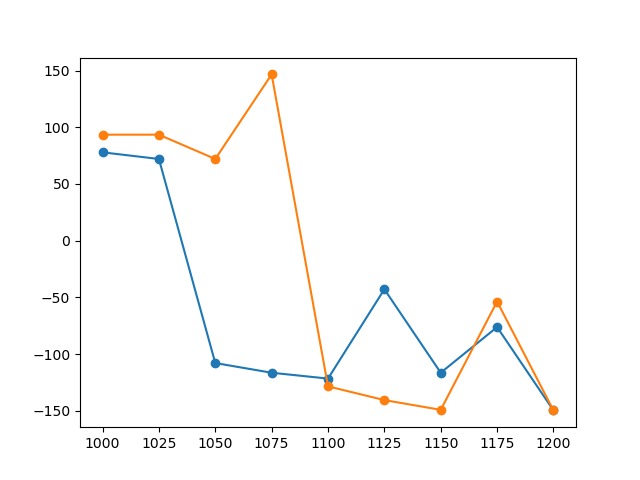

8.999831239765422

In [302]:
def pop_vec_sepraration(wh,itcal_state,cue1,cue2,seed=1234):
    s_times,s_senders,s_place_CA1,s_place_CA3,CA3_lfp_sig,CA1_lfp_sig,lfp_sig_ts,pf_CA3,pf_CA1 = sim_wrapper(data,wh,itcal_state,1350,cue1,1000,cue_weight=1500,bg_w=10,seed=seed)
    #pop_vec_CA3,time_vec = population_vector(s_times,s_senders,np.arange(0,len(pf_CA3),1),pf_CA3)
    pop_vec_CA1,time_vec_1 = population_vector(s_times,s_senders,np.arange(1250,1250+len(pf_CA1),1),pf_CA1)

    s_times,s_senders,s_place_CA1,s_place_CA3,CA3_lfp_sig,CA1_lfp_sig,lfp_sig_ts,pf_CA3,pf_CA1 = sim_wrapper(data,wh,itcal_state,1350,cue2,1000,cue_weight=1500,bg_w=10,seed=seed)
    #pop_vec_CA3_2,time_vec = population_vector(s_times,s_senders,np.arange(0,len(pf_CA3),1),pf_CA3)
    pop_vec_CA1_2,time_vec_2 = population_vector(s_times,s_senders,np.arange(1250,1250+len(pf_CA1),1),pf_CA1)

    # the resultatnt pvs should be different. lets measure the difference between the two pvs using correlation
    # get the correlation between the two population vectors CA1 only 
    
    # first make sure that the two population vectors are the same size by interpolating the larger one to the smaller one
    t_common = []
    if len(pop_vec_CA1) >= len(pop_vec_CA1_2):
        f = interpolate.interp1d(time_vec_1,pop_vec_CA1,fill_value='extrapolate')
        pop_vec_CA1 = f(time_vec_2)
        t_common = time_vec_2

    elif len(pop_vec_CA1) < len(pop_vec_CA1_2):
        f = interpolate.interp1d(time_vec_2,pop_vec_CA1_2,fill_value='extrapolate')
        pop_vec_CA1_2 = f(time_vec_1)
        t_common = time_vec_1

    # euclidean distance between the end points of the two population vectors at 1050 ms
    # nearest index to 1050 ms
    t_common_idx = np.argmin(np.abs(t_common-1050))
    sep_CA1 = np.abs(pop_vec_CA1[t_common_idx] - pop_vec_CA1_2[t_common_idx])
    
    # and then only correlate the two population vectors
    pop_vec_CA1 = pop_vec_CA1[(t_common>=1000) & (t_common<=1300)]
    pop_vec_CA1_2 = pop_vec_CA1_2[(t_common>=1000) & (t_common<=1300)]

    # normalize by cue distances' centers
    midpt_1 = np.mean(cue1)
    midpt_2 = np.mean(cue2)

    sep_CA1 /= np.abs(midpt_1-midpt_2)

    plt.close('all')
    plt.figure()
    plt.plot(t_common[(t_common>=1000) & (t_common<=1300)],pop_vec_CA1,'-o')
    plt.plot(t_common[(t_common>=1000) & (t_common<=1300)],pop_vec_CA1_2,'-o')
    plt.show()

    return sep_CA1

pop_vec_sepraration(wh,True,[70,90],[90,110],seed=1819)


Aug 03 19:10:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 03 19:10:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 1350
    Number of OpenMP threads: 16
    Not using MPI

Aug 03 19:10:28 SimulationManager::run [Info]: 
    Simulation finished.

Aug 03 19:10:29 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 03 19:10:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 1350
    Number of OpenMP threads: 16
    Not using MPI

Aug 03 19:10:30 SimulationManager::run [Info]: 
    Simulation finished.

Aug 03 19:10:31 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 03 19:10:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 1350
    Number of OpenMP threads: 16
    Not using MPI

Aug 03 19:10:33 SimulationManager::run [Info

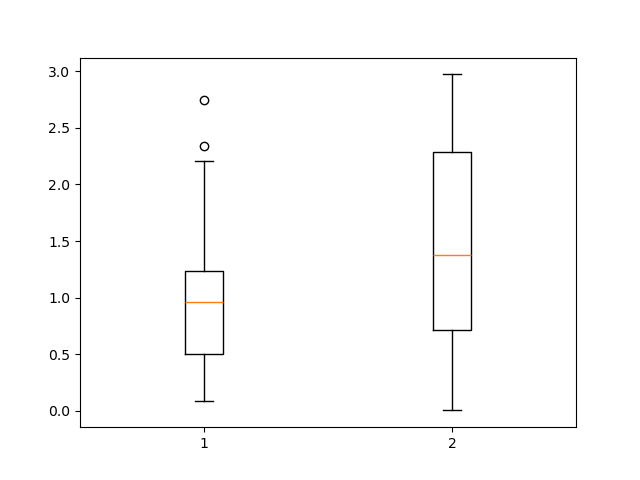

In [291]:
# for each cue location, we will run the simulation N_sim times and get the correlation between the population vectors
wh = 0
N_sim = 30
cue1 = [20,40]
cue2 = [90,110] # this is the ictal cue location

corr_CA1_ctrl = np.zeros(N_sim)
for i in range(N_sim):
    corr_CA1_ctrl[i] = pop_vec_sepraration(wh,False,cue1,cue2,seed=i+1)

corr_CA1_ictal = np.zeros(N_sim)
for i in range(N_sim):
    corr_CA1_ictal[i] = pop_vec_sepraration(wh,True,cue1,cue2,seed=i+1)

plt.close('all')
plt.figure()
plt.boxplot([corr_CA1_ctrl,corr_CA1_ictal])
plt.show()

In [292]:
_,p = ttest_ind(corr_CA1_ctrl,corr_CA1_ictal,equal_var=False)
print(p)

0.04493855555978228


In [423]:
def pop_vec_endpt(wh,itcal_state,cue,seed=1234):
    s_times,s_senders,_,_,_,_,_,_,pf_CA1 = sim_wrapper(data,wh,itcal_state,150,cue,50,cue_weight=1500,bg_w=0,seed=seed)
    pop_vec_CA1,time_vec_1 = population_vector(s_times,s_senders,np.arange(1250,1250+len(pf_CA1),1),pf_CA1)

    # euclidean distance between the end points of the two population vectors at wall time
    t_common_idx = np.argmin(np.abs(time_vec_1-90))
    sep_CA1 = pop_vec_CA1[t_common_idx]

    return sep_CA1

pop_vec_endpt(0,False,[90,110],seed=11)


Aug 03 20:03:59 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 03 20:03:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 150
    Number of OpenMP threads: 16
    Not using MPI

Aug 03 20:03:59 SimulationManager::run [Info]: 
    Simulation finished.


122.1910772281031

In [424]:
N_sim = 100
cue1 = [90,110]
end_pts_CA1_ctrl = np.zeros(N_sim)
end_pts_CA1_ic = np.zeros(N_sim)

for i in range(N_sim):
    # pick a wh randomly
    whh = np.random.randint(0,10)
    end_pts_CA1_ctrl[i] = pop_vec_endpt(whh,False,cue1,seed=i+1)
    end_pts_CA1_ic[i] = pop_vec_endpt(whh,True,cue1,seed=i+1)


Aug 03 20:04:08 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 03 20:04:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 150
    Number of OpenMP threads: 16
    Not using MPI

Aug 03 20:04:08 SimulationManager::run [Info]: 
    Simulation finished.

Aug 03 20:04:09 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 03 20:04:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 150
    Number of OpenMP threads: 16
    Not using MPI

Aug 03 20:04:09 SimulationManager::run [Info]: 
    Simulation finished.

Aug 03 20:04:10 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 03 20:04:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 150
    Number of OpenMP threads: 16
    Not using MPI

Aug 03 20:04:10 SimulationManager::run [Info]: 

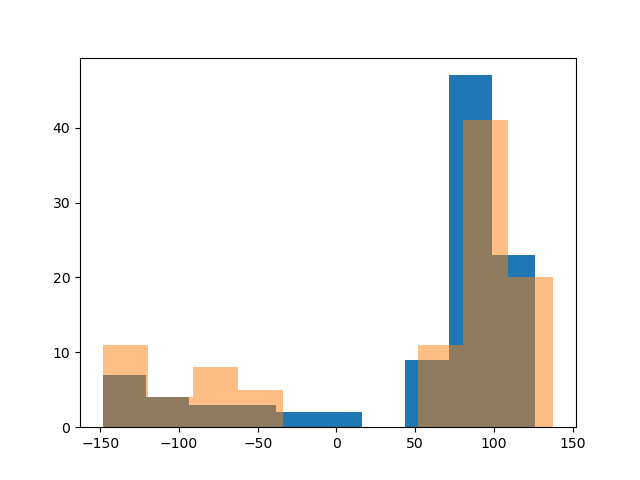

In [425]:
plt.close('all')
plt.figure()
plt.hist(end_pts_CA1_ctrl)
plt.hist(end_pts_CA1_ic,alpha=0.5)
plt.show()

In [579]:
plt.savefig('popvec_raster_ka_inset.svg')

In [564]:
states_CA1 = utils.bin_series(pop_vec_CA1,b=50)
states_CA3 = utils.bin_series(pop_vec_CA3,b=50)

te = transfer_entropy(states_CA1[0],states_CA3[0],1)
te

0.9797256008665912

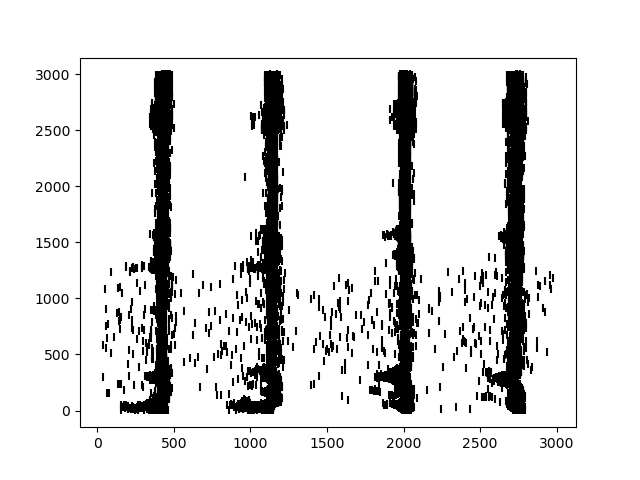

In [266]:
plt.close('all')
#plt.figure(dpi=300,figsize=(8,3))
plt.figure()
plt.scatter(s_times,s_senders,marker='|',color='k')
plt.show()

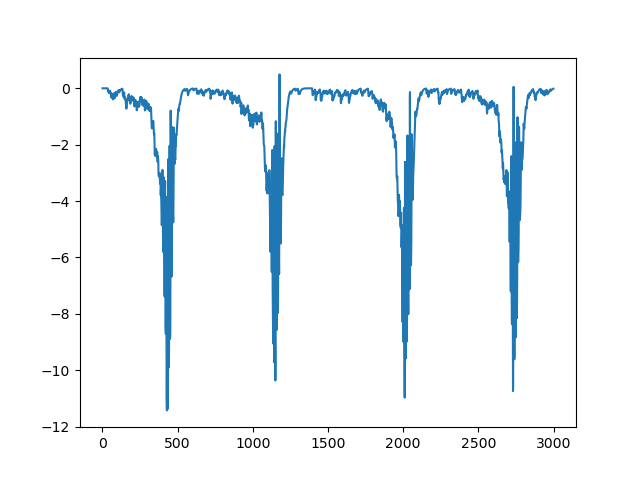

In [265]:
plt.close('all')
#plt.figure(dpi=300,figsize=(8,3))
plt.figure()
plt.plot(lfp_sig_ts,CA1_lfp_sig)
plt.show()

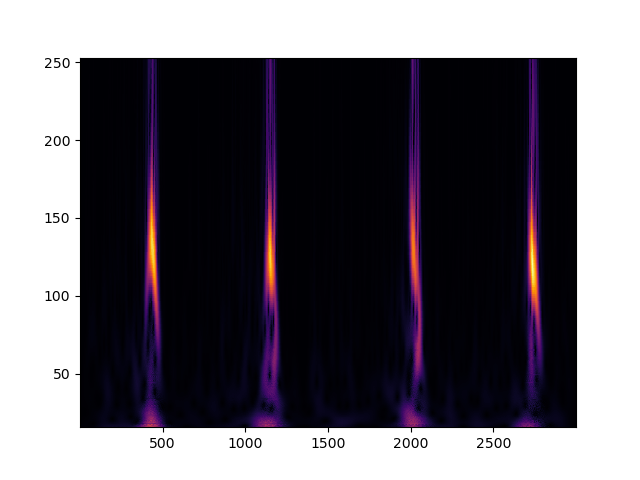

In [264]:
from scipy import signal
import pywt

fs = 1000
freqs = np.logspace(1.2,2.4,200)/fs
scale = pywt.frequency2scale('cmor1.5-1.0', freqs)

coef, freqs=pywt.cwt(CA1_lfp_sig,scale,'cmor1.5-1.0',1/fs)

plt.close('all')
plt.figure()
#plt.figure(dpi=300,figsize=(8,3))
plt.pcolormesh(lfp_sig_ts,freqs,np.abs(coef))
#plt.yscale('log')
plt.show()

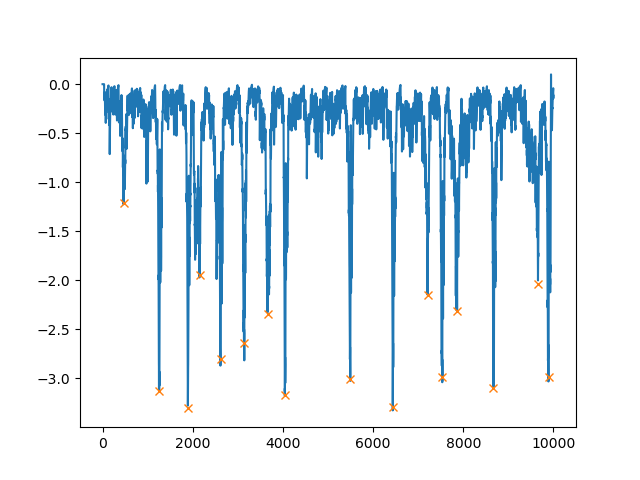

In [194]:
butt_lp = signal.butter(7, 200, 'low', fs=fs, output='sos')
CA1_lfp_sig_filt = signal.sosfilt(butt_lp,CA1_lfp_sig)
peaks,_=signal.find_peaks(-CA1_lfp_sig_filt,prominence=1,distance=200)
# for each peak, grab the lfp between -wid and wid ms
wid = 150
each_osc = []
t_osc = []
Pxx_osc = []
f_osc = []
for i in range(len(peaks)):
    left_idx = np.argmin(np.abs(lfp_sig_ts-(lfp_sig_ts[peaks[i]]-wid)))
    right_idx = np.argmin(np.abs(lfp_sig_ts-(lfp_sig_ts[peaks[i]]+wid)))
    each_osc.append(CA1_lfp_sig[left_idx:right_idx])

    # the time, centered around the peak
    t_osc.append(lfp_sig_ts[left_idx:right_idx]-lfp_sig_ts[peaks[i]])

    # welch spectrum
    f, Pxx = signal.welch(CA1_lfp_sig[left_idx:right_idx],fs=fs,nperseg=256,noverlap=32,nfft=1024)
    Pxx_osc.append(Pxx)
    f_osc.append(f)


plt.close('all')
plt.figure()
plt.plot(lfp_sig_ts,CA1_lfp_sig)
plt.plot(lfp_sig_ts[peaks],CA1_lfp_sig_filt[peaks],'x')
plt.show()

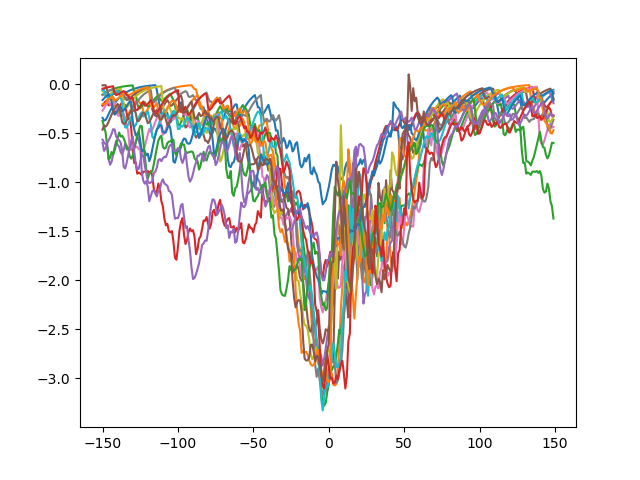

In [195]:
plt.close('all')
plt.figure()
for i in range(len(each_osc)):
    plt.plot(t_osc[i],each_osc[i])
plt.show()

In [5]:
def compute_filter_and_segements(lfp_sig,lfp_sig_ts,fs=1000,wid=150,give_ts=False):
    butt_lp = signal.butter(7, 200, 'low', fs=fs, output='sos')
    lfp_sig_filt = signal.sosfilt(butt_lp,lfp_sig)
    peaks,_=signal.find_peaks(-lfp_sig_filt,prominence=1,distance=200)
    
    # for each peak, grab the lfp between -wid and wid ms
    each_osc = []
    t_osc = []
    ts_osc = [] # the time in absolute time
    for i in range(len(peaks)):
        left_idx = np.maximum(np.argmin(np.abs(lfp_sig_ts-(lfp_sig_ts[peaks[i]]-wid))),0)
        right_idx = np.minimum(np.argmin(np.abs(lfp_sig_ts-(lfp_sig_ts[peaks[i]]+wid))),len(lfp_sig_ts)-1)
        
        # if not long enough, pad with zeros
        if right_idx-left_idx < 2*wid:
            pad = 2*wid-(right_idx-left_idx)
            each_osc.append(np.pad(lfp_sig[left_idx:right_idx],(0,pad)))
        else:
            each_osc.append(lfp_sig[left_idx:right_idx])

        # the time, centered around the peak
        t_osc.append(np.arange(0,2*wid,1)-wid)

        # the time in absolute time
        ts_osc.append(np.linspace(lfp_sig_ts[left_idx],lfp_sig_ts[left_idx]+2*wid,len(each_osc[-1])))

    if give_ts:
        return each_osc,t_osc,ts_osc
    else:
        return each_osc,t_osc

def cwt_compare(wh,tmax=5000,seed=1234):
    fs = 1000
    
    # s_times,s_senders,s_place_CA1,s_place_CA3,CA3_lfp_sig,CA1_lfp_sig,lfp_sig_ts,pf_CA3,pf_CA1
    _,_,_,_,_,CA1_lfp_sig_ctrl,lfp_sig_ts_ctrl,_,_ = sim_wrapper(data,wh,False,tmax,[-60,-40],2000,cue_weight=0,seed=seed)
    _,_,_,_,_,CA1_lfp_sig_ictal,lfp_sig_ts_ictal,_,_ = sim_wrapper(data,wh,True,tmax,[-60,-40],2000,cue_weight=0,seed=seed)

    each_osc_ctrl,t_osc_ctrl = compute_filter_and_segements(CA1_lfp_sig_ctrl,lfp_sig_ts_ctrl)
    each_osc_ictal,t_osc_ictal = compute_filter_and_segements(CA1_lfp_sig_ictal,lfp_sig_ts_ictal)

    # cwt of mean oscillation
    freqs = np.logspace(1.2,2.5,200)/fs
    scale = pywt.frequency2scale('cmor1.5-1.0', freqs)
    mean_osc_ctrl = np.mean(each_osc_ctrl,axis=0)
    mean_osc_ictal = np.mean(each_osc_ictal,axis=0)

    coef_ctrl, freqs=pywt.cwt(mean_osc_ctrl,scale,'cmor1.5-1.0',1/fs)
    coef_ictal, freqs=pywt.cwt(mean_osc_ictal,scale,'cmor1.5-1.0',1/fs)

    return t_osc_ctrl[0],freqs,np.abs(coef_ctrl),np.abs(coef_ictal),mean_osc_ctrl,mean_osc_ictal

In [ ]:
t_osc_ctrl,freqs,coef_ctrl,coef_ictal,mean_osc_ctrl,mean_osc_ictal = cwt_compare(0)

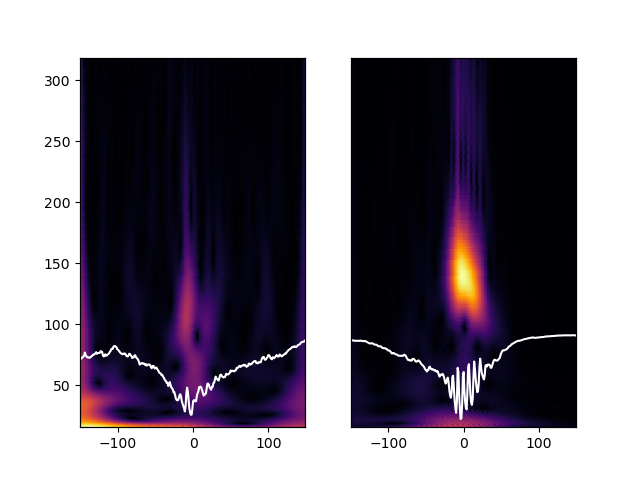

In [434]:
plt.close('all')
plt.figure()
plt.set_cmap('inferno')
plt.subplot(121)
#plt.title('Control')
plt.pcolormesh(t_osc_ctrl,freqs,np.abs(coef_ctrl))
#plt.ylabel('Frequency (Hz)')
#plt.xlabel('Time (ms)')
#plt.colorbar()
plt.twinx()
plt.plot(t_osc_ctrl,mean_osc_ctrl,'w')
plt.ylim([-4,10])
plt.yticks([])

plt.subplot(122)
#plt.title('Interictal spike')
plt.pcolormesh(t_osc_ctrl,freqs,np.abs(coef_ictal))
#plt.xlabel('Time (ms)')
#plt.colorbar()
plt.yticks([])
plt.twinx()
plt.plot(t_osc_ctrl,mean_osc_ictal,'w')
plt.ylim([-10,30])
plt.yticks([])
plt.show()

In [212]:
def compute_spontaneous_hfo_spectra(tmax=5000,seed=1234):
    fs = 1000
    spectra_control = []
    spectra_ictal = []

    for wh in range(10):
        _,_,_,_,_,CA1_lfp_sig_ctrl,CA1_lfp_sig_ctrl_ts,_,_ = sim_wrapper(data,wh,False,tmax,[-60,-40],2000,cue_weight=0,seed=seed)
        _,_,_,_,_,CA1_lfp_sig_ictal,CA1_lfp_sig_ictal_ts,_,_ = sim_wrapper(data,wh,True,tmax,[-60,-40],2000,cue_weight=0,seed=seed)

        each_osc_ctrl = []
        Pxx_osc_ctrl = []
        f_osc_ctrl = []

        # use compute_filter_and_segements to get the segments
        each_osc_ctrl,_ = compute_filter_and_segements(CA1_lfp_sig_ctrl)

        # for each segment, compute the welch spectrum
        for i in range(len(each_osc_ctrl)):
            f, Pxx = signal.welch(each_osc_ctrl[i],fs=fs,nperseg=256,noverlap=32,nfft=1024)
            Pxx_osc_ctrl.append(Pxx)
            f_osc_ctrl.append(f)
        
        each_osc_ictal = []
        Pxx_osc_ictal = []
        f_osc_ictal = []

        # use compute_filter_and_segements to get the segments
        each_osc_ictal,_ = compute_filter_and_segements(CA1_lfp_sig_ictal)

        # for each segment, compute the welch spectrum
        for i in range(len(each_osc_ictal)):
            f, Pxx = signal.welch(each_osc_ictal[i],fs=fs,nperseg=256,noverlap=32,nfft=1024)
            Pxx_osc_ictal.append(Pxx)
            f_osc_ictal.append(f)

        # append all the mean spectrum
        spectra_control.append(np.mean(Pxx_osc_ctrl,axis=0))
        spectra_ictal.append(np.mean(Pxx_osc_ictal,axis=0))

    return f_osc_ctrl[0],spectra_control,spectra_ictal

f_osc_ctrl,spectra_control,spectra_ictal = compute_spontaneous_hfo_spectra()


Aug 01 16:03:37 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 01 16:03:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 5000
    Number of OpenMP threads: 16
    Not using MPI

Aug 01 16:03:44 SimulationManager::run [Info]: 
    Simulation finished.

Aug 01 16:03:45 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 01 16:03:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 5000
    Number of OpenMP threads: 16
    Not using MPI

Aug 01 16:03:51 SimulationManager::run [Info]: 
    Simulation finished.

Aug 01 16:03:52 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 01 16:03:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 5000
    Number of OpenMP threads: 16
    Not using MPI

Aug 01 16:03:58 SimulationManager::run [Info

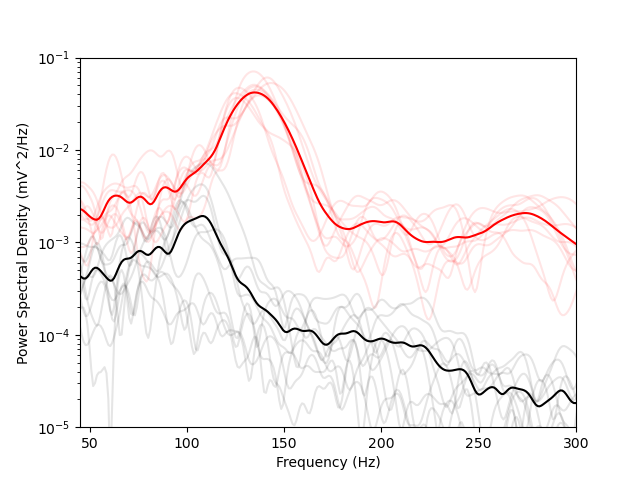

In [227]:
plt.close('all')
plt.figure()
for i in range(10):
    plt.plot(f_osc_ctrl,spectra_control[i],'k',alpha=0.1)
    plt.plot(f_osc_ctrl,spectra_ictal[i],'r',alpha=0.1)
plt.plot(f_osc_ctrl,np.mean(spectra_control,axis=0),'k',label='Control')
plt.plot(f_osc_ctrl,np.mean(spectra_ictal,axis=0),'r',label='Ictal')
plt.yscale('log')
plt.xlim([45,300])
plt.ylim([1e-5,1e-1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (mV^2/Hz)')
#plt.legend()
plt.show()


In [568]:
def compute_and_compare_te(tmax=5000,b=30,seed=1234):
    tes = []
    for wh in range(10):
        # compute the control and ictal transfer entropy
        s_times_ctrl,s_senders_ctrl,_,_,_,_,_,pf_CA3_ctrl,pf_CA1_ctrl = sim_wrapper(data,wh,False,tmax,[-60,-40],2000,cue_weight=0,seed=seed+wh)
        s_times_ictal,s_senders_ictal,_,_,_,_,_,pf_CA3_ictal,pf_CA1_ictal = sim_wrapper(data,wh,True,tmax,[-60,-40],2000,cue_weight=0,seed=seed+wh)

        # compute population vector
        pop_vec_CA1_ctrl,_ = population_vector(s_times_ctrl,s_senders_ctrl,np.arange(1250,1250+len(pf_CA1_ctrl),1),pf_CA1_ctrl)
        pop_vec_CA3_ctrl,_ = population_vector(s_times_ctrl,s_senders_ctrl,np.arange(0,len(pf_CA3_ctrl),1),pf_CA3_ctrl)

        pop_vec_CA1_ictal,_ = population_vector(s_times_ictal,s_senders_ictal,np.arange(1250,1250+len(pf_CA1_ictal),1),pf_CA1_ictal)
        pop_vec_CA3_ictal,_ = population_vector(s_times_ictal,s_senders_ictal,np.arange(0,len(pf_CA3_ictal),1),pf_CA3_ictal)

        # compute the transfer entropy
        states_CA1_ctrl = utils.bin_series(pop_vec_CA1_ctrl,b=b)
        states_CA3_ctrl = utils.bin_series(pop_vec_CA3_ctrl,b=b)

        states_CA1_ictal = utils.bin_series(pop_vec_CA1_ictal,b=b)
        states_CA3_ictal = utils.bin_series(pop_vec_CA3_ictal,b=b)

        te_ctrl = transfer_entropy(states_CA3_ctrl[0],states_CA1_ctrl[0],1)
        te_ictal = transfer_entropy(states_CA3_ictal[0],states_CA1_ictal[0],1)

        tes.append([te_ctrl,te_ictal])
    return np.array(tes)

tes = compute_and_compare_te()


Aug 02 15:38:24 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 02 15:38:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 5000
    Number of OpenMP threads: 16
    Not using MPI

Aug 02 15:38:30 SimulationManager::run [Info]: 
    Simulation finished.

Aug 02 15:38:32 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 02 15:38:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 5000
    Number of OpenMP threads: 16
    Not using MPI

Aug 02 15:38:38 SimulationManager::run [Info]: 
    Simulation finished.

Aug 02 15:38:39 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 02 15:38:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 5000
    Number of OpenMP threads: 16
    Not using MPI

Aug 02 15:38:44 SimulationManager::run [Info

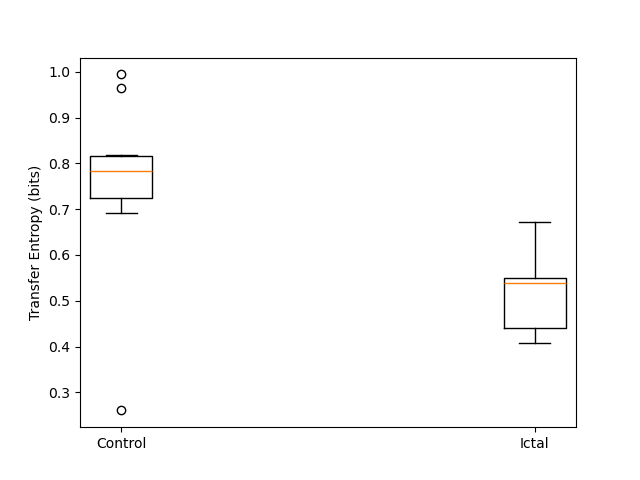

In [590]:
# boxplot of transfer entropy
plt.close('all')
plt.figure()
plt.boxplot(tes)
plt.xticks([1,2],['Control','Ictal'])
plt.ylabel('Transfer Entropy (bits)')
plt.xlim([0.9,2.1])
plt.show()

In [592]:
_,p = ttest_ind(tes[:,0],tes[:,1],equal_var=False,alternative='greater')
p

0.0021116188120855585

In [681]:
###################################
###################################
###################################
# THIS IS NOT WORKING AS EXPECTED...
###################################
###################################
###################################

def compute_hfo_to_hfo_spike_pat_cor(tmax = 5000,seed=1234):
    fs = 1000
    L_grab = 500
    hfo_spike_cor = np.array((2,1))
    for wh in range(1):
        s_times_ctrl,s_senders_ctrl,_,_,_,CA1_lfp_sig_ctrl,CA1_lfp_sig_ctrl_ts,_,pf_CA1_ctrl = sim_wrapper(data,wh,False,tmax,[-60,-40],2000,cue_weight=0,seed=seed)
        s_times_ictal,s_senders_ictal,_,_,_,CA1_lfp_sig_ictal,CA1_lfp_sig_ictal_ts,_,pf_CA1_ictal = sim_wrapper(data,wh,True,tmax,[-60,-40],2000,cue_weight=0,seed=seed)

        # get the times of the HFOs using compute_filter_and_segements
        lfp_ctrl_CA1,t_c_osc_ctrl_CA1,t_osc_ctrl_CA1 = compute_filter_and_segements(CA1_lfp_sig_ctrl,CA1_lfp_sig_ctrl_ts,wid=L_grab,give_ts=True)
        lfp_ictal_CA1,t_c_osc_ictal_CA1,t_osc_ictal_CA1 = compute_filter_and_segements(CA1_lfp_sig_ictal,CA1_lfp_sig_ictal_ts,wid=L_grab,give_ts=True)

        # for each segment, get the CA1 place cell activity and bin it into a matrix
        # bin time into b ms bins
        b = 30
        states_CA1_ctrl = []
        ts_pv_ctrl = []
        states_CA1_ictal = []
        ts_pv_ictal = []

        # compute population vectors and times
        pop_vec_CA1_ctrl,pop_vec_CA1_ctrl_t = population_vector(s_times_ctrl,s_senders_ctrl,np.arange(1250,1250+len(pf_CA1_ctrl),1),pf_CA1_ctrl,t_bin=b)
        pop_vec_CA1_ictal,pop_vec_CA1_ictal_t = population_vector(s_times_ictal,s_senders_ictal,np.arange(1250,1250+len(pf_CA1_ictal),1),pf_CA1_ictal,t_bin=b)

        for i in range(len(t_osc_ctrl_CA1)):
            # get the pop vec values that occurs in t_osc..., interplate so that the time vector is the same
            pop_vec_CA1_ctrl_t_idx = (pop_vec_CA1_ctrl_t>=t_osc_ctrl_CA1[i][0]) & (pop_vec_CA1_ctrl_t<t_osc_ctrl_CA1[i][-1])
            pop_vec_CA1_ctrl_t_interp = interpolate.interp1d(pop_vec_CA1_ctrl_t[pop_vec_CA1_ctrl_t_idx],pop_vec_CA1_ctrl[pop_vec_CA1_ctrl_t_idx],fill_value='extrapolate',kind='linear')
            states_CA1_ctrl.append(pop_vec_CA1_ctrl_t_interp(pop_vec_CA1_ctrl_t[pop_vec_CA1_ctrl_t_idx]))
            ts_pv_ctrl.append(pop_vec_CA1_ctrl_t[pop_vec_CA1_ctrl_t_idx])

        for i in range(len(t_osc_ictal_CA1)):
            # get the pop vec values that occurs in t_osc..., interplate so that the time vector is the same
            pop_vec_CA1_ictal_t_idx = (pop_vec_CA1_ictal_t>=t_osc_ictal_CA1[i][0]) & (pop_vec_CA1_ictal_t<t_osc_ictal_CA1[i][-1])
            pop_vec_CA1_ictal_t_interp = interpolate.interp1d(pop_vec_CA1_ictal_t[pop_vec_CA1_ictal_t_idx],pop_vec_CA1_ictal[pop_vec_CA1_ictal_t_idx],fill_value='extrapolate',kind='linear')
            states_CA1_ictal.append(pop_vec_CA1_ictal_t_interp(pop_vec_CA1_ictal_t[pop_vec_CA1_ictal_t_idx]))
            ts_pv_ictal.append(pop_vec_CA1_ictal_t[pop_vec_CA1_ictal_t_idx])

        # compute the correlation between each unique pair of pv and then average
        temp_corr_ctrl = []
        temp_corr_ictal = []
        for i in range(len(states_CA1_ctrl)):
            for j in range(i+1,len(states_CA1_ctrl)):
                temp_corr_ctrl.append(np.corrcoef(states_CA1_ctrl[i],states_CA1_ctrl[j])[0,1])
                
        for i in range(len(states_CA1_ictal)):
            for j in range(i+1,len(states_CA1_ictal)):
                temp_corr_ictal.append(np.corrcoef(states_CA1_ictal[i],states_CA1_ictal[j])[0,1])

        # average the correlation
        hfo_spike_cor[0,wh] = np.mean(temp_corr_ctrl)
        hfo_spike_cor[1,wh] = np.mean(temp_corr_ictal)
    
    return hfo_spike_cor,states_CA1_ctrl,states_CA1_ictal,ts_pv_ctrl,ts_pv_ictal,t_osc_ctrl_CA1,t_osc_ictal_CA1,lfp_ctrl_CA1,lfp_ictal_CA1

mean_corr,states_CA1_ctrl,states_CA1_ictal,ts_pv_ctrl,ts_pv_ictal,t_osc_ctrl_CA1,t_osc_ictal_CA1,lfp_ctrl_CA1,lfp_ictal_CA1 = compute_hfo_to_hfo_spike_pat_cor()


Aug 02 19:41:03 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 02 19:41:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 5000
    Number of OpenMP threads: 16
    Not using MPI

Aug 02 19:41:11 SimulationManager::run [Info]: 
    Simulation finished.

Aug 02 19:41:12 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 02 19:41:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 5000
    Number of OpenMP threads: 16
    Not using MPI

Aug 02 19:41:19 SimulationManager::run [Info]: 
    Simulation finished.


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 33 and the array at index 1 has size 34

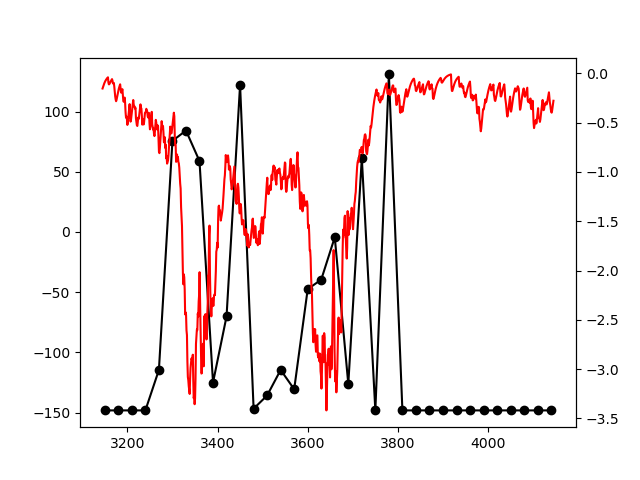

In [692]:
wh_p = 4
plt.close('all')
plt.figure()
plt.plot(ts_pv_ctrl[wh_p],states_CA1_ctrl[wh_p],'-ok')
plt.twinx()
plt.plot(t_osc_ctrl_CA1[wh_p],lfp_ctrl_CA1[wh_p],'r')
plt.show()

In [8]:
def compute_replay_pv_entropy(tmax=5000,b=30,seed=1234):
    fs = 1000
    L_grab = 150
    Hs = []
    for wh in range(10):
        s_times_ctrl,s_senders_ctrl,_,_,_,CA1_lfp_sig_ctrl,CA1_lfp_sig_ctrl_ts,_,pf_CA1_ctrl = sim_wrapper(data,wh,False,tmax,[-60,-40],2000,cue_weight=0,seed=seed+wh)
        s_times_ictal,s_senders_ictal,_,_,_,CA1_lfp_sig_ictal,CA1_lfp_sig_ictal_ts,_,pf_CA1_ictal = sim_wrapper(data,wh,True,tmax,[-60,-40],2000,cue_weight=0,seed=seed+wh)

        # get the times of the HFOs using compute_filter_and_segements
        _,_,t_osc_ctrl_CA1 = compute_filter_and_segements(CA1_lfp_sig_ctrl,CA1_lfp_sig_ctrl_ts,wid=L_grab,give_ts=True)
        _,_,t_osc_ictal_CA1 = compute_filter_and_segements(CA1_lfp_sig_ictal,CA1_lfp_sig_ictal_ts,wid=L_grab,give_ts=True)

        # for each segment, get the CA1 PV 
        # bin time into b ms bins
        states_CA1_ctrl = []
        states_CA1_ictal = []

        # compute population vectors and times
        pop_vec_CA1_ctrl,pop_vec_CA1_ctrl_t = population_vector(s_times_ctrl,s_senders_ctrl,np.arange(1250,1250+len(pf_CA1_ctrl),1),pf_CA1_ctrl)
        pop_vec_CA1_ictal,pop_vec_CA1_ictal_t = population_vector(s_times_ictal,s_senders_ictal,np.arange(1250,1250+len(pf_CA1_ictal),1),pf_CA1_ictal)

        for i in range(len(t_osc_ctrl_CA1)):
            # get the pop vec values that occurs in t_osc...,
            pop_vec_CA1_ctrl_t_idx = (pop_vec_CA1_ctrl_t>=t_osc_ctrl_CA1[i][0]) & (pop_vec_CA1_ctrl_t<t_osc_ctrl_CA1[i][-1])
            states_CA1_ctrl.append(pop_vec_CA1_ctrl[pop_vec_CA1_ctrl_t_idx])

        for i in range(len(t_osc_ictal_CA1)):
            # get the pop vec values that occurs in t_osc..., interplate so that the time vector is the same
            pop_vec_CA1_ictal_t_idx = (pop_vec_CA1_ictal_t>=t_osc_ictal_CA1[i][0]) & (pop_vec_CA1_ictal_t<t_osc_ictal_CA1[i][-1])
            states_CA1_ictal.append(pop_vec_CA1_ictal[pop_vec_CA1_ictal_t_idx])
            
        # flatten to concatenate
        states_CA1_ctrl = np.concatenate(states_CA1_ctrl)
        states_CA1_ictal = np.concatenate(states_CA1_ictal)

        # bin the states
        states_CA1_ctrl_binned = utils.bin_series(states_CA1_ctrl,b=b)[0]
        states_CA1_ictal_binned = utils.bin_series(states_CA1_ictal,b=b)[0]

        # compute dists
        Dist_ctrl = dist.Dist(states_CA1_ctrl_binned)
        Dist_ictal = dist.Dist(states_CA1_ictal_binned)

        # compute the entropy
        H_ctrl = shannon.entropy(Dist_ctrl)
        H_ictal = shannon.entropy(Dist_ictal)

        Hs.append([H_ctrl,H_ictal])

    return np.array(Hs)

Hs = compute_replay_pv_entropy(tmax=10000)


Aug 05 13:36:32 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 05 13:36:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 10000
    Number of OpenMP threads: 16
    Not using MPI

Aug 05 13:36:46 SimulationManager::run [Info]: 
    Simulation finished.

Aug 05 13:36:48 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 05 13:36:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 10000
    Number of OpenMP threads: 16
    Not using MPI

Aug 05 13:37:03 SimulationManager::run [Info]: 
    Simulation finished.

Aug 05 13:37:05 NodeManager::prepare_nodes [Info]: 
    Preparing 3080 nodes for simulation.

Aug 05 13:37:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3080
    Simulation time (ms): 10000
    Number of OpenMP threads: 16
    Not using MPI

Aug 05 13:37:19 SimulationManager::run [I

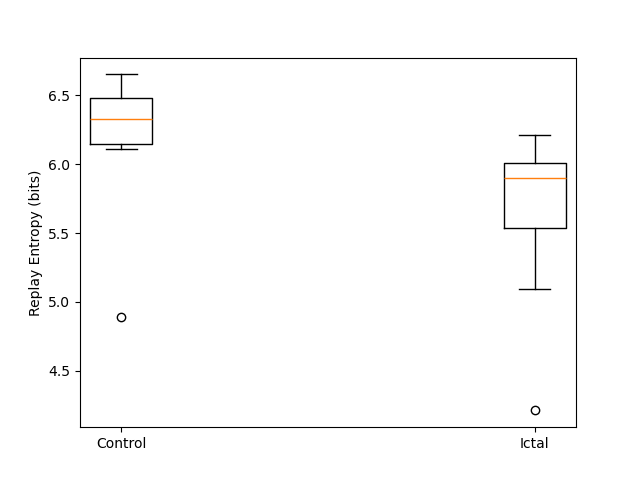

In [9]:
# box plot of replay entropy
plt.close('all')
plt.figure()
plt.boxplot(Hs)
plt.xticks([1,2],['Control','Ictal'])
plt.ylabel('Replay Entropy (bits)')
plt.xlim([0.9,2.1])
plt.show()

In [11]:
plt.savefig('replay_entropy_boxplot.svg')

In [10]:
_,p= ttest_ind(Hs[:,0],Hs[:,1],equal_var=False,alternative='greater')
p

0.020466036823165622